In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

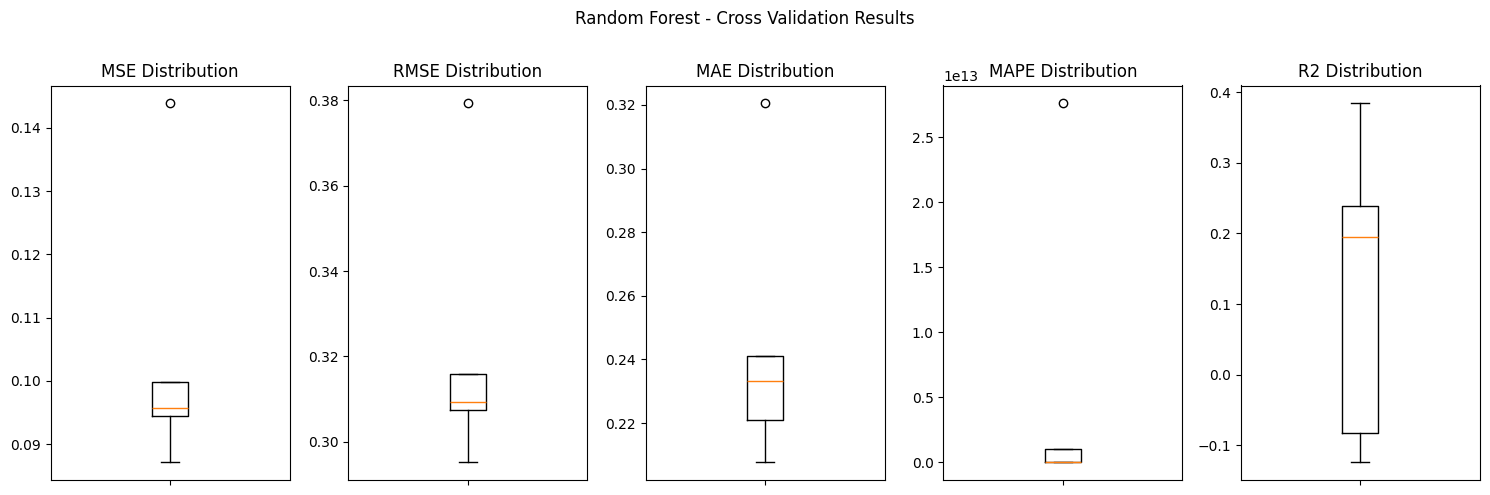


Random Forest Results:

Average Training Metrics:
MSE: 0.0182
RMSE: 0.1341
MAE: 0.0977
MAPE: 1840651888380.0945
R2: 0.9446

Average Test Metrics:
MSE: 0.1042
RMSE: 0.3214
MAE: 0.2447
MAPE: 5726682473541.7148
R2: 0.1224

Average Feature Importance (Top 5):
cpi_lag_1: 0.2248
rolling_reserves_6m: 0.1204
cpi_volatility_3m: 0.0956
interest_lag_1: 0.0930
Interest_Rate: 0.0790


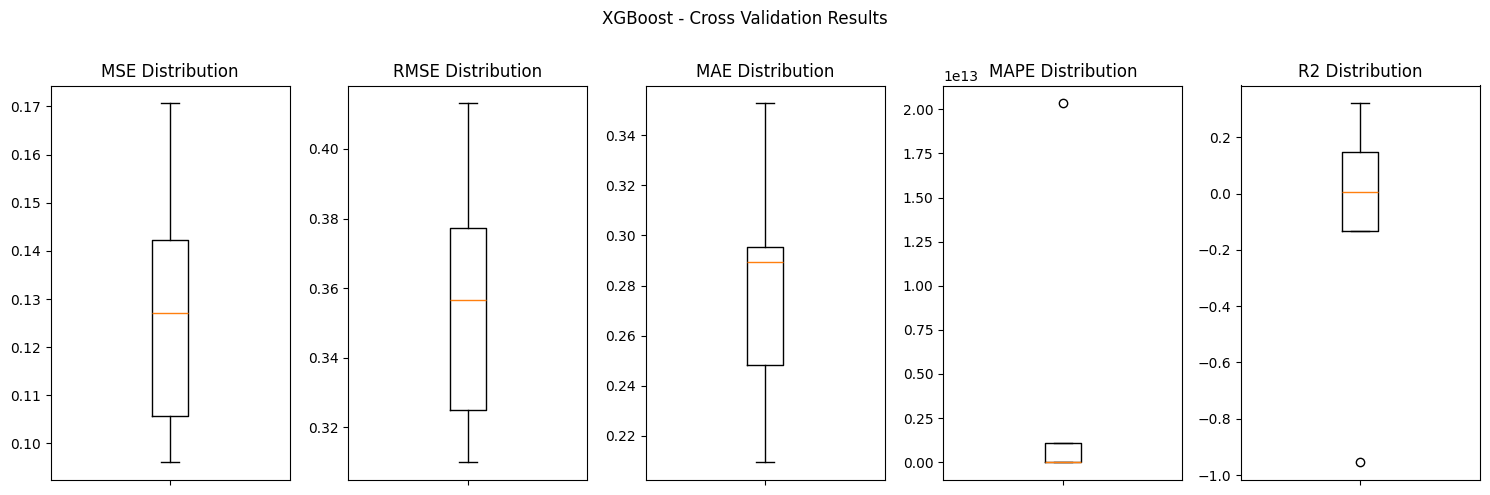


XGBoost Results:

Average Training Metrics:
MSE: 0.0000
RMSE: 0.0007
MAE: 0.0006
MAPE: 15154608028.3361
R2: 1.0000

Average Test Metrics:
MSE: 0.1284
RMSE: 0.3564
MAE: 0.2790
MAPE: 4282468181780.1807
R2: -0.1224

Average Feature Importance (Top 5):
rolling_monetary_6m: 0.4862
rolling_reserves_6m: 0.2099
cpi_lag_1: 0.1367
interest_lag_1: 0.0199
cpi_volatility_3m: 0.0188


In [20]:
def prepare_features(df):
    # Convert the first column to datetime
    df['Date'] = pd.to_datetime(df.iloc[:, 0])
    df = df.drop(df.columns[0], axis=1)
    
    column_names = {
        '': 'Date',
        'SF31991_Banco de Mexico, Recursos en moneda extranjera, Reserva Internacional (Definida de acuerdo con la Ley del Banco de Mexico de Abril de 1994)': 'International_Reserves',
        'SP30577_Índice Nacional de Precios al consumidor Variacion mensual': 'CPI_Monthly_Variation',
        'SG41_Ingresos y Gastos Presupuestales del Sector Publico Medicion por Ingreso-Gasto, Flujos de Caja Balance publico Balance presupuestario': 'Budget_Balance',
        'SF29652_Base Monetaria': 'Monetary_Base',
        'SF283_TIIE a 28 dias Tasa de interes promedio mensual, en por ciento anual': 'Interest_Rate'
    }

    df = df.rename(columns=column_names)
    
    df_processed = df.copy()
    
    # Log transform for exponential features
    df_processed['log_monetary_base'] = np.log1p(df_processed['Monetary_Base'])
    df_processed['log_international_reserves'] = np.log1p(df_processed['International_Reserves'])
    
    # Create lagged features (previous 3 months)
    for i in range(1, 4):
        df_processed[f'cpi_lag_{i}'] = df_processed['CPI_Monthly_Variation'].shift(i)
        df_processed[f'interest_lag_{i}'] = df_processed['Interest_Rate'].shift(i)
    
    # Rolling means and standard deviations
    for window in [3, 6]:  # Adding 6-month window for longer-term patterns
        df_processed[f'rolling_monetary_{window}m'] = df_processed['log_monetary_base'].rolling(window=window).mean()
        df_processed[f'rolling_reserves_{window}m'] = df_processed['log_international_reserves'].rolling(window=window).mean()
        df_processed[f'rolling_budget_{window}m'] = df_processed['Budget_Balance'].rolling(window=window).mean()
        df_processed[f'cpi_volatility_{window}m'] = df_processed['CPI_Monthly_Variation'].rolling(window=window).std()
        df_processed[f'interest_volatility_{window}m'] = df_processed['Interest_Rate'].rolling(window=window).std()
    
    df_processed = df_processed.dropna()
    return df_processed

def evaluate_predictions(y_true, y_pred):
    """Calculate multiple evaluation metrics"""
    metrics = {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    return metrics

def plot_cv_results(cv_results, title):
    """Plot cross-validation metrics across folds"""
    metrics = list(cv_results[0].keys())
    n_folds = len(cv_results)
    
    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, len(metrics), i)
        values = [fold[metric] for fold in cv_results]
        plt.boxplot(values)
        plt.title(f'{metric} Distribution')
        plt.xticks([1], [''])
    plt.suptitle(f'{title} - Cross Validation Results')
    plt.tight_layout()
    plt.show()

def plot_train_test_predictions(y_train, y_train_pred, y_test, y_test_pred, title):
    """Plot actual vs predicted values for both training and test sets"""
    plt.figure(figsize=(12, 5))
    
    # Training set
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Training Set')
    
    # Test set
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Test Set')
    
    plt.suptitle(f'{title} - Actual vs Predicted')
    plt.tight_layout()
    plt.show()

def train_evaluate_model(df):
    df_processed = prepare_features(df)
    
    # Define features
    features = [col for col in df_processed.columns 
               if col != 'CPI_Monthly_Variation' and col != 'Date']
    
    X = df_processed[features]
    y = df_processed['CPI_Monthly_Variation']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=features)
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        cv_results = []
        train_metrics = []
        test_metrics = []
        feature_importance = []
        
        for train_idx, test_idx in tscv.split(X_scaled):
            X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Fit model
            model.fit(X_train, y_train)
            
            # Get predictions
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Evaluate
            train_fold_metrics = evaluate_predictions(y_train, y_train_pred)
            test_fold_metrics = evaluate_predictions(y_test, y_test_pred)
            
            train_metrics.append(train_fold_metrics)
            test_metrics.append(test_fold_metrics)
            cv_results.append(test_fold_metrics)
            
            # Store feature importance
            if name == 'Random Forest':
                importance = model.feature_importances_
            else:
                importance = model.feature_importances_
            feature_importance.append(dict(zip(features, importance)))
        
        # Store results
        results[name] = {
            'cv_results': cv_results,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'feature_importance': feature_importance
        }
        
        # Plot results
        plot_cv_results(cv_results, name)
        
        # Calculate and print average metrics
        print(f"\n{name} Results:")
        print("\nAverage Training Metrics:")
        avg_train = {k: np.mean([m[k] for m in train_metrics]) for k in train_metrics[0]}
        for metric, value in avg_train.items():
            print(f"{metric}: {value:.4f}")
            
        print("\nAverage Test Metrics:")
        avg_test = {k: np.mean([m[k] for m in test_metrics]) for k in test_metrics[0]}
        for metric, value in avg_test.items():
            print(f"{metric}: {value:.4f}")
        
        # Print feature importance
        print("\nAverage Feature Importance (Top 5):")
        avg_importance = {}
        for feature in features:
            avg_importance[feature] = np.mean([fold[feature] for fold in feature_importance])
        
        sorted_features = dict(sorted(avg_importance.items(), key=lambda x: x[1], reverse=True))
        for feature, importance in list(sorted_features.items())[:5]:
            print(f"{feature}: {importance:.4f}")
    
    return results

def main():
    # Load data
    df = pd.read_csv('output/Inflation_Rate_Variables_Dataset.csv')
    
    # Train and evaluate models
    results = train_evaluate_model(df)

if __name__ == "__main__":
    main()